In [1]:
import tensorflow as tf
yawn_model = tf.keras.models.load_model('my_model_mouth.keras')

C:\Users\durva\OneDrive\NTU courses\SEM 2\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
eye_model = tf.keras.models.load_model('my_model_eyes.h5')

# let us now create a function to detect both the yawning and eye state using our models that we have previously trained

    

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
mouth_cascade = mouth_cascade = cv2.CascadeClassifier('haarcascade_mcs_mouth.xml')  # Assuming you have a mouth cascade


def display_image(img, title='Image'):
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')  # Hide axis
    plt.show()

def predict(input_image):
    # Load the image
    img = cv2.imread(input_image)
    if img is None:
        print("Image not loaded, check the file path.")
        return

    # Display the original image
    display_image(img, 'Original Image')

    # Convert to grayscale for Haar Cascade
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected.")
        return

    for (x, y, w, h) in faces:
        # Crop the face from the image
        roi_color = img[y:y+h, x:x+w]

        # Display the cropped face region
        display_image(roi_color, 'Cropped Face Region')

        # Convert the face region to grayscale for eye and mouth detection
        roi_gray = cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY)

        # Detect eyes within the face region
        eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (ex, ey, ew, eh) in eyes:
            # Crop the eye region from the color face ROI
            eye_roi = roi_color[ey:ey+eh, ex:ex+ew]

            # Display the cropped eye region
            display_image(eye_roi, 'Cropped Eye Region')

            # Preprocess the eye ROI for the neural network
            # Resize, expand dimensions, and normalize
            eye_roi = cv2.resize(eye_roi, (224, 224))
            eye_roi = eye_roi / 255.0
            eye_roi = np.expand_dims(eye_roi, axis=0)

            # Predict using the loaded model
            prediction = eye_model.predict(eye_roi)
            print(prediction)

            # Output prediction
            if prediction > 0.5:
                print("Your eye is open.")
            else:
                print("Your eye is closed.")

        # Consider only the lower half of the face for mouth detection
        roi_color_lower = roi_color[h//2:h, :]
        roi_gray_lower = cv2.cvtColor(roi_color_lower, cv2.COLOR_BGR2GRAY)

        # Detect mouth within the lower face region
        mouths = mouth_cascade.detectMultiScale(roi_gray_lower, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        if len(mouths) > 0:
            mx, my, mw, mh = mouths[0]
            # Crop the mouth region from the color lower face ROI
            mouth_roi = roi_color_lower[my:my+mh, mx:mx+mw]

            # Display the cropped mouth region
            display_image(mouth_roi, 'Cropped Mouth Region')

            # Preprocess the mouth ROI for the neural network
            mouth_roi = cv2.resize(mouth_roi, (224, 224))
            mouth_roi = mouth_roi / 255.0
            mouth_roi = np.expand_dims(mouth_roi, axis=0)

            # Predict using the loaded model
            prediction = yawn_model.predict(mouth_roi)
            print(prediction)

            # Output prediction
            if prediction > 0.5:
                print("You are yawning.")
            else:
                print("You are not yawning.")
        else:
            print("No mouth detected in the face region.")




# lets test it out

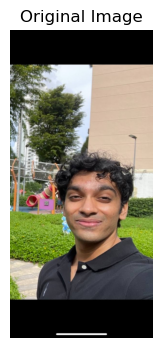

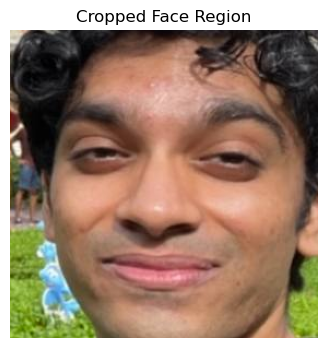

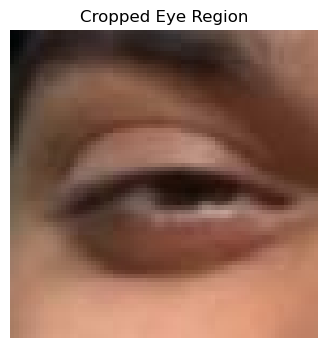

1/1 [==============================] - 2s 2s/step
[[0.9898422]]
Your eye is open.


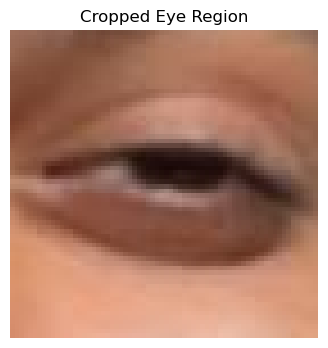

1/1 [==============================] - 0s 103ms/step
[[0.7047136]]
Your eye is open.


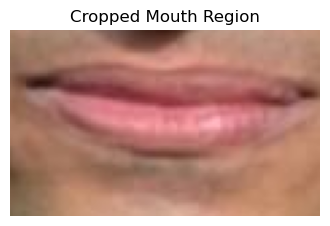

1/1 [==============================] - 1s 925ms/step
[[1.8260966e-05]]
You are not yawning.


In [4]:
predict('myimage2.jpg')

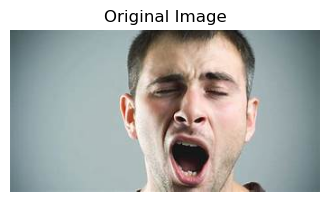

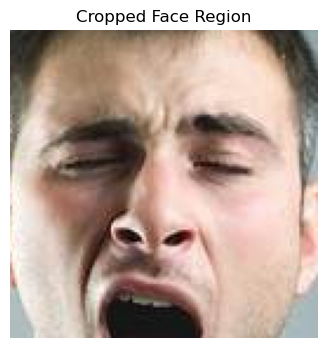

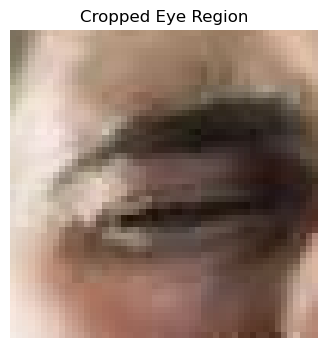

1/1 [==============================] - 0s 97ms/step
[[0.0437839]]
Your eye is closed.


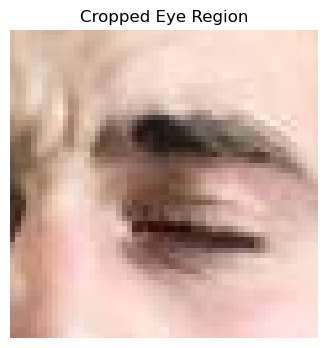

1/1 [==============================] - 0s 93ms/step
[[0.84945333]]
Your eye is open.


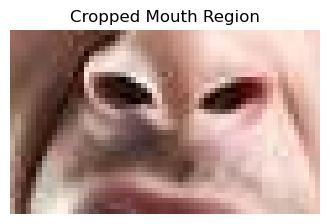

1/1 [==============================] - 0s 158ms/step
[[0.9817262]]
You are yawning.


In [5]:
predict('online_image.jpg')

# i guess it is relatively accurate

# now lets try to do this real time

In [3]:
# Open the webcam
def predict_real_time():
    # Open the webcam
    cap = cv2.VideoCapture(0)

    while True:
        # Capture frame-by-frame
        ret, img = cap.read()

        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
            roi_color = img[y:y+h, x:x+w]
            roi_gray = gray[y:y+h, x:x+w]

            eyes = eye_cascade.detectMultiScale(roi_gray)
            for (ex, ey, ew, eh) in eyes:
                cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
                eye_roi = roi_color[ey:ey+eh, ex:ex+ew]
                eye_roi = cv2.resize(eye_roi, (224, 224))
                eye_roi = eye_roi / 255.0
                eye_roi = np.expand_dims(eye_roi, axis=0)
                eye_pred = eye_model.predict(eye_roi)
                if eye_pred > 0.5:
                    eye_text = "Open"
                else:
                    eye_text = "Closed"
                cv2.putText(img, eye_text, (x+ex, y+ey-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

            roi_color_lower = roi_color[h//2:h, :]
            roi_gray_lower = gray[y+h//2:y+h, x:x+w]
            mouths = mouth_cascade.detectMultiScale(roi_gray_lower)

            for (mx, my, mw, mh) in mouths:
                cv2.rectangle(roi_color_lower, (mx, my), (mx+mw, my+mh), (0, 0, 255), 2)
                mouth_roi = roi_color_lower[my:my+mh, mx:mx+mw]
                mouth_roi = cv2.resize(mouth_roi, (224, 224))
                mouth_roi = mouth_roi / 255.0
                mouth_roi = np.expand_dims(mouth_roi, axis=0)
                yawn_pred = yawn_model.predict(mouth_roi)
                if yawn_pred > 0.5:
                    yawn_text = "Yawning"
                else:
                    yawn_text = "Not Yawning"
                cv2.putText(img, yawn_text, (x+mx, y+h//2+my-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)

        # Display the resulting frame
        cv2.imshow('Video', img)

        # Break the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything is done, release the capture
    cap.release()
    cv2.destroyAllWindows()


In [4]:
predict_real_time()

NameError: name 'cv2' is not defined

## it was a bit annoying will all the rectangles being displayed and the state results being showed at my face features itself so i modified it a bit

In [6]:
def predict_real_time():
    # Open the webcam
    cap = cv2.VideoCapture(0)

    while True:
        # Capture frame-by-frame
        ret, img = cap.read()

        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Initialize the status messages
        eye_status = "Eye: Not Detected"
        yawn_status = "Yawn: Not Detected"

        for (x, y, w, h) in faces:
            roi_color = img[y:y+h, x:x+w]
            roi_gray = gray[y:y+h, x:x+w]

            # Eye detection
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) > 0:
                # Just use the first eye detected for simplicity
                ex, ey, ew, eh = eyes[0]
                eye_roi = roi_color[ey:ey+eh, ex:ex+ew]
                eye_roi = cv2.resize(eye_roi, (224, 224))
                eye_roi = eye_roi / 255.0
                eye_roi = np.expand_dims(eye_roi, axis=0)
                eye_pred = eye_model.predict(eye_roi)
                eye_status = "Eye: Open" if eye_pred > 0.5 else "Eye: Closed"

            # Mouth detection for yawning in the lower half of the face region
            roi_color_lower = roi_color[h//2:h, :]
            roi_gray_lower = gray[y+h//2:y+h, x:x+w]
            mouths = mouth_cascade.detectMultiScale(roi_gray_lower)
            if len(mouths) > 0:
                mx, my, mw, mh = mouths[0]
                mouth_roi = roi_color_lower[my:my+mh, mx:mx+mw]
                mouth_roi = cv2.resize(mouth_roi, (224, 224))
                mouth_roi = mouth_roi / 255.0
                mouth_roi = np.expand_dims(mouth_roi, axis=0)
                yawn_pred = yawn_model.predict(mouth_roi)
                yawn_status = "Yawn: Yawning" if yawn_pred > 0.5 else "Yawn: Not Yawning"

        # Display the statuses in the corner of the frame
        cv2.putText(img, eye_status, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(img, yawn_status, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Display the resulting frame
        cv2.imshow('Video', img)

        # Break the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything is done, release the capture
    cap.release()
    cv2.destroyAllWindows()

# Remember to initialize eye_model and yawn_model with your actual models before calling this function


In [7]:
predict_real_time()

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


# okay the model seems to work sufficently well